# P and S wave recovery

In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import pymultinest
from seispy.station.stationdata import SeismometerArray
from seispy.station import StationArray, spiral, homestake
from seispy.seispy_io import read_config, print_params
from scipy.linalg import pinv2,svd
from scipy.sparse.linalg import lsqr
import astropy.units as u
import os
import numpy as np
import ConfigParser
import optparse
from collections import OrderedDict
import seispy.plotter.plot as hplot
import matplotlib.tri as mtri
from mpl_toolkits import mplot3d
import healpy as hp
import NX01_AnisCoefficients as anis
import AnisCoefficients_pix as pixAnis

/home/meyers/opt/seispy/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
amplitude = 1e-4
strs = ['p','s1','s2']

# set up array
stations = spiral(8, radius=300)
#stations = homestake()
stations = homestake(['A4850', 'B4850', 'D2000','800','RRDG', 'C4100', 'ROSS'])
distances = []
# get some white data
data = SeismometerArray.initialize_all_good(stations, 1000, chans_type='fast')
# get spot size
snames = data.keys()
for station in snames:
    for station2 in snames:
        diff_dir = np.asarray(stations[station]) -\
            np.asarray(stations[station2])
        distances.append(np.sqrt(np.dot(diff_dir,diff_dir)))

spot_size = 5700 / (2 * 5 * max(distances))
lmax = int(np.pi / spot_size)+ 1
print 'lmax roughly is: %d' %  int(lmax+1)

# add some white noise
#data.add_white_noise(1e-24, 100)
# add injection
#data.add_p_wave(amplitude, np.radians(60), np.radians(120), 1,1000, c=5700)
data.add_s_wave(1e-4, np.radians(0), np.radians(120), 0, 5, 1000, c=3000)

lmax roughly is: 16


In [3]:
# get coherences
Ys = data.get_coherences(5, fftlength=100, overlap=50, window='hann')

In [4]:
# get p-wave matrices
G2, phis2, thetas2, shapes2 = data.get_gamma_matrix_healpy('p',
        stations,5,5700)
# get r-wave matrices

#G1, phis1, thetas1, shapes1 = data.get_gamma_matrix_healpy('s', stations,
#        1, 3000)
# get shapes
shapes = []
#shapes.extend(shapes1)
shapes.extend(shapes2)
# stack matrices
#G = np.vstack((G2, G1)).T
G = G2.T
#G = G2.T
G2 = None
G1 = None
#G = np.tile(G, (nsamps,1))
# combine angles associated with one axies
# of gamma matrices. keep track of
# shapes
#phis = np.hstack((phis1, phis2))
phis = phis2
#thetas = np.hstack((thetas1, thetas2))
thetas = thetas2


Rank of matrix is: 92


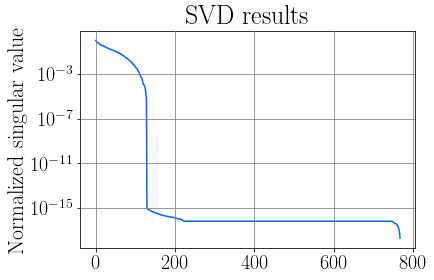

In [5]:
# do svd 
U,s,Vh = svd(np.dot(G.T,G))
# get rank using cutoff of 1e-5
rank = np.sum(s > 1e-2 * np.max(s))
print 'Rank of matrix is: %d' % rank
plt.figure()
plt.plot(s/max(s))
ax = plt.gca()
ax.set_yscale('log')
plt.ylabel('Normalized singular value')
plt.title('SVD results')
plt.show()

In [6]:
# do matrix inversion
Y = np.mean(Ys, 1)
N_inv = 1e24 * np.diag(np.ones(Y.size))
N = 1e-24 * np.diag(np.ones(Y.size))
X = np.real(np.dot(G.T,Y))
#    Gamma_pinv = pinv2(Gamma, rcond=1e-3)
G_pinv = pinv2(np.real(np.dot(G.T, G)), rcond=1e-2)
S = np.real(np.dot(G_pinv, X))

#S = lsqr(np.real(np.dot(G.T, G)), np.real(np.dot(G.T, Y)))[0]
#cov = np.real(np.dot(np.dot(G.T, N_inv), G))
cov=None
model = np.real(np.dot(G,S))
dat = (Y - model)
ll = -0.5 * np.real(np.dot(np.dot(dat.conj().T, N_inv), dat))
ll2 = -0.5 * np.real(np.dot(np.dot(Y.conj().T, N_inv), Y))
lratio = ll - ll2
print 'Log Likelihood ratio: %f' % lratio

Log Likelihood ratio: 855534920510.124023


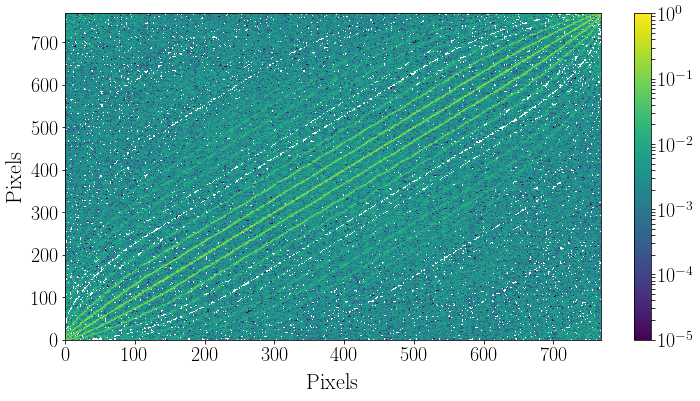

In [7]:
# Model resolution matrix
MRM = np.dot(G_pinv, np.real(np.dot(G.T, G)))
plt.figure(figsize=(12,6))
plt.pcolormesh(MRM, norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=1))
plt.colorbar()
plt.xlabel('Pixels')
plt.ylabel('Pixels')
#plt.savefig('model_resolution_matrix')
plt.show()
MRM_diag = np.diag(MRM)

/home/meyers/opt/seispy/lib/python2.7/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


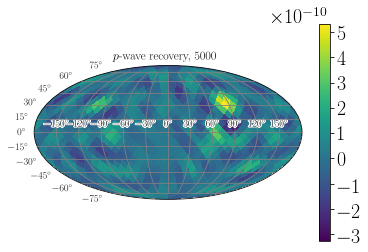

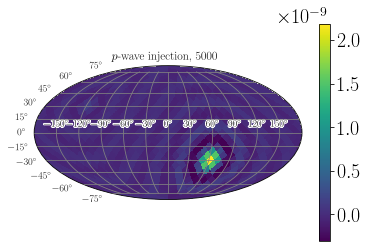

Match parameter: -0.022390


In [8]:
idx0=0
vlist=[5000,1000,1000]
phi_injs = [60,120,0]
theta_injs = [120, 90, 0]
inj_powers = [1e-4, 1e-4, 0]
for ii,shape in enumerate(shapes):
    # get shape, get the phis and thetas
    # for this particular map.
    shape = shape[0]
    phis_temp = phis[idx0:idx0+shape]
    thetas_temp = thetas[idx0:idx0+shape]
    # Extract this map.
    S_temp = S[idx0:idx0+shape] / 100
    inj_map = np.zeros(S_temp.shape)
    inj_map_ini = np.zeros(S_temp.shape)
    nside = 8
    
    # Create an injection map:
    # 1. add power to single pixel associated with sky direction
    # 2. convert to spherical harmonics, but only use up lmax
    #     associated with expected spot size
    # 3. convert back to pixel basis
    uni_thetas = np.unique(thetas)
    unts = uni_thetas.size
    if strs[ii] == 'r':
        for jj in xrange(uni_thetas.size):
            idx = hp.pixelfunc.ang2pix(nside, uni_thetas[jj], np.radians(phi_injs[ii]))
            inj_map_ini[idx] = 1
        P_inj = pixAnis.clmFromMap(inj_map_ini, lmax-6) * inj_powers[ii]**2
        P_inj[0] = 1e-12
        inj_map = pixAnis.mapFromClm(P_inj, nside)
    else:
        idx = hp.pixelfunc.ang2pix(nside, np.radians(theta_injs[ii]), np.radians(phi_injs[ii]))
        inj_map[idx] = 1
        P_inj = pixAnis.clmFromMap(inj_map, lmax-3) * inj_powers[ii]**2
        P_inj[0] = 1e-12
        inj_map = pixAnis.mapFromClm(P_inj, nside)
    
    
    # plot recovery map
    ax = plt.subplot(111, projection='mollweide')
    hplot.healpix_heatmap(S_temp, cmap='viridis')
    hplot.outline_text(ax)
    ax.grid(True)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    plt.colorbar()
    ax.set_title(r'$%s$-wave recovery, %d' % (strs[ii], vlist[ii]), fontsize=12)
    #plt.savefig('%s_recovery' % (strs[ii]))
    #plt.close()
    plt.show()
    
    
    # plot injection map
    ax = plt.subplot(111, projection='mollweide')
    hplot.healpix_heatmap(inj_map, cmap='viridis')
    hplot.outline_text(ax)
    ax.grid(True)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    plt.colorbar()
    ax.set_title(r'$%s$-wave injection, %d' % (strs[ii],vlist[ii]), fontsize=12)
    plt.show()
    
    # plot injection map before sph
#     ax = plt.subplot(111, projection='mollweide')
#     hplot.healpix_heatmap(inj_map_ini, cmap='viridis')
#     hplot.outline_text(ax)
#     ax.grid(True)
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(10)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(10)
#     plt.colorbar()
#     ax.set_title(r'$%s$-wave injection, %d' % (strs[ii],vlist[ii]), fontsize=12)
#     plt.show()
    #plt.savefig('%s_injection' % (strs[ii]))
    #plt.close()
    
    # Calculate projection of recovered map onto injected map
    match = np.dot(inj_map, S_temp) / np.sqrt(np.dot(inj_map,inj_map) *
            np.dot(S_temp, S_temp))
    print 'Match parameter: %f' % match
    idx0+=shape